<a href="https://colab.research.google.com/github/TheGreymanShow/pytorch-CNN-CIFAR10/blob/master/pytorch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

2. Define CNN Architechture

In [0]:
class CNN(nn.Module):
    """
    CNN Class that defines the CNN Model
    """

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x

3. Load data into train and test

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


4. Load the model, loss function and optimizer

In [0]:
# Define CNN model
net = CNN()
net = net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True

# Define the Loss Function
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

 5. Train the model

In [0]:
train_loss = []
test_loss = []

train_acc = []
test_acc = []

print("Starting Training...\n")
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    train_correct = 0
    train_total =0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate the training loss
        #running_loss += loss.item()

        # accumulate the training acc score
        #_, predicted = torch.max(outputs.data, 1)
        #train_total += labels.size(0)
        #train_correct += (predicted == labels).sum().item()
    
    #train_acc.append(100 * train_correct/train_total)
    #train_loss.append(running_loss / len(trainloader))

    # Calculate the test accuracy and loss
    correct = 0
    total = 0
    running_loss_test = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data

            images = images.cuda()
            labels = labels.cuda()

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
          
            #loss = criterion(outputs, labels)
            #running_loss_test += loss.item()

    test_acc.append(100 * correct/total)
    #test_loss.append(running_loss_test / len(testloader))

    print(f"Epoch : {epoch}")
    print(f"Test accuracy : {100 * correct/total}")
    #print(f"Train loss : {running_loss / len(trainloader)} ------ Test Loss: {running_loss_test / len(testloader)}\n")

print('Finished Training')

Starting Training...

Epoch : 0
Test accuracy : 64.77
Epoch : 1
Test accuracy : 71.84
Epoch : 2
Test accuracy : 78.27
Epoch : 3
Test accuracy : 81.45
Epoch : 4
Test accuracy : 81.98
Epoch : 5
Test accuracy : 81.73
Epoch : 6
Test accuracy : 82.84
Epoch : 7
Test accuracy : 81.39
Epoch : 8
Test accuracy : 82.99
Epoch : 9
Test accuracy : 82.12
Finished Training


6. Save the trained model

In [0]:
print('==> Saving model ...')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

==> Saving model ...


In [0]:
from google.colab import files
files.download('./cifar_net.pth')

7. Load the saved model

In [0]:
net2 = CNN()
net2 = net2.cuda()
net2 = torch.nn.DataParallel(net2, device_ids=range(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True

PATH = './cifar_net.pth'
net2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

8. Evaluate Model accuracy

In [0]:
y_pred = []
y_true = []

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:

        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        inputs, labels = Variable(inputs), Variable(labels)

        net2.eval()

        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_true.extend(labels)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


9. Evaluate other performance metrics

In [0]:
from sklearn.metrics import *
y_pred = [int(x.cpu().detach().item()) for x in y_pred]
y_true = [int(x.cpu().detach().item()) for x  in y_true]

In [0]:
y_true[:10]

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]

In [0]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.88      0.95      0.92      1000
           2       0.75      0.79      0.77      1000
           3       0.69      0.73      0.71      1000
           4       0.83      0.85      0.84      1000
           5       0.76      0.79      0.78      1000
           6       0.92      0.82      0.87      1000
           7       0.92      0.84      0.88      1000
           8       0.93      0.89      0.91      1000
           9       0.91      0.88      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[865  14  43  16  10   3   4   2  21  22]
 [  4 950   1   1   2   3   0   0   6  33]
 [ 41   4 790  39  45  41  24  11   4   1]
 [ 11   4  52 734  31 120  21  13   8   6]
 [  4   1  39  46 853  24  10  19   4   0]
 [  6   6  29 109  24 792  11  18   1   4]
 [  5   1  50  66  27  11 825   4   9   2]
 [ 10   0  25  34  35  43   2 844   1   6]
 [ 43  23  13   8   1   3   1   1 893  14]
 [ 15  72   7   4   2   1   1   4  13 881]]


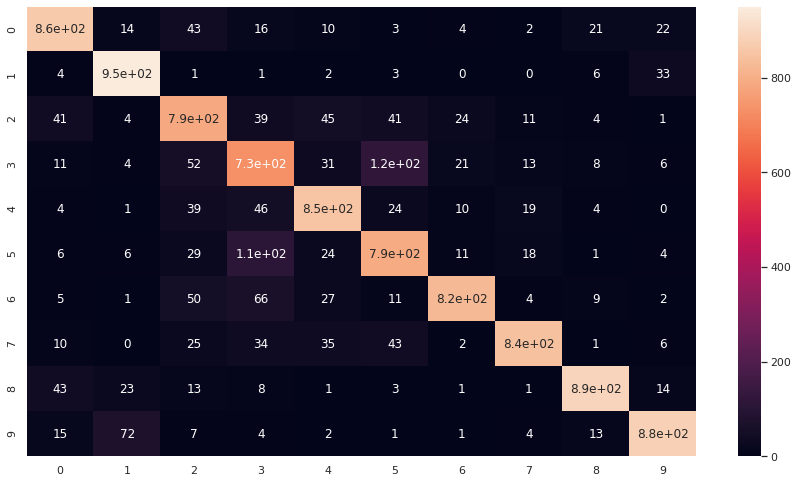

In [0]:
# Better Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set(rc={'figure.figsize':(15,8.27)})
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

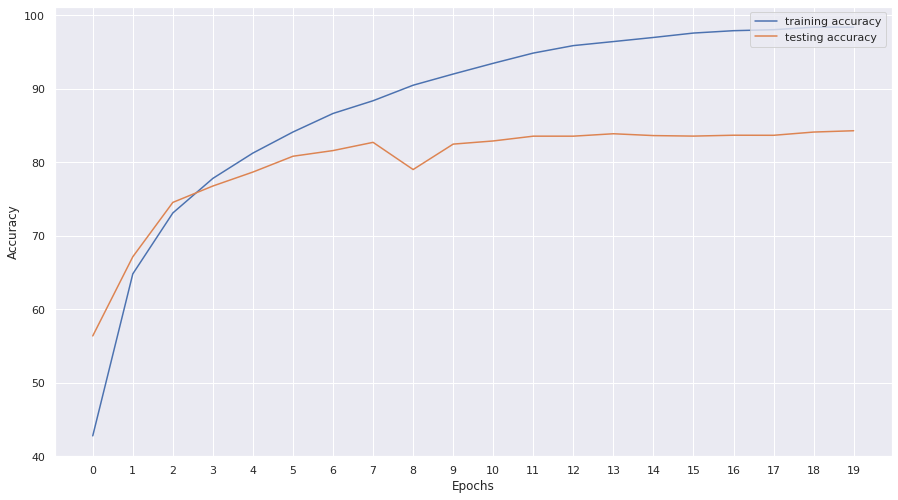

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_acc, label='training accuracy')
plt.plot(test_acc, label='testing accuracy')
plt.xticks(np.arange(0,20,step=1))
plt.legend(loc="upper right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

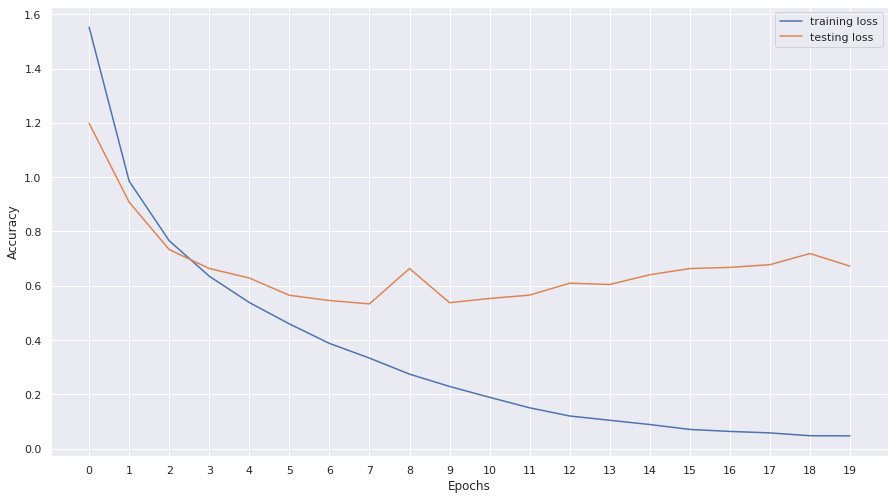

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label='testing loss')
plt.xticks(np.arange(0,20,step=1))
plt.legend(loc="upper right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

**1. Batch Norm vs Non-Batch Norm: Effect on convergence of Model**

In [0]:
nonbatchnorm_acc_a = [0, 10.0,
 10.0,
 12.34,
 14.6,
 26.49,
 36.93,
 44.01,
 50.06,
 52.59,
 56.75,
 62.05,
 63.92,
 66.97,
 67.06,
 70.31,
 70.53,
 70.17,
 73.13,
 73.56,
 74.31]

nonbatchnorm_acc_b = [0, 37.89,
 55.58,
 67.56,
 74.65,
 74.84,
 78.92,
 77.85,
 80.84,
 79.44,
 79.77,
 79.94,
 80.54,
 80.58,
 81.0,
 79.69,
 80.98,
 80.91,
 81.01,
 79.55,
 80.68]

nonbatchnorm_acc_c = [0, 44.97,
 64.13,
 71.76,
 74.41,
 77.79,
 76.56,
 77.49,
 75.66,
 75.86,
 75.28,
 73.54,
 77.31,
 74.78,
 72.67,
 74.13,
 70.32,
 66.47,
 64.19,
 62.13,
 52.54]


#batchnorm_acc_a = [0, 57.1, 66.56,74.53,76.35,80.28,80.28,80.13,80.13,81.97,81.7,83.53,82.66,83.83,83.24,82.45,84.15,83.1,83.99,83.47,83.71]
batchnorm_acc_c = [0] + test_acc


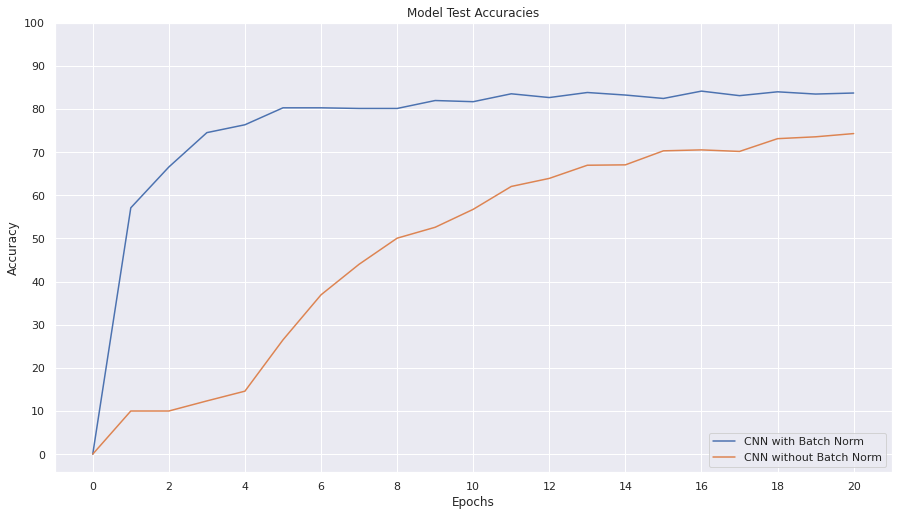

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.title("Model Test Accuracies")
plt.plot(batchnorm_acc_a, label='CNN with Batch Norm')
plt.plot(nonbatchnorm_acc_a, label='CNN without Batch Norm')
plt.yticks(np.arange(0,110,step=10))
plt.xticks(np.arange(0,21,step=2))
plt.legend(loc="lower right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

**2. Batch Norm vs Non-Batch Norm: Effect of higher learning rate**

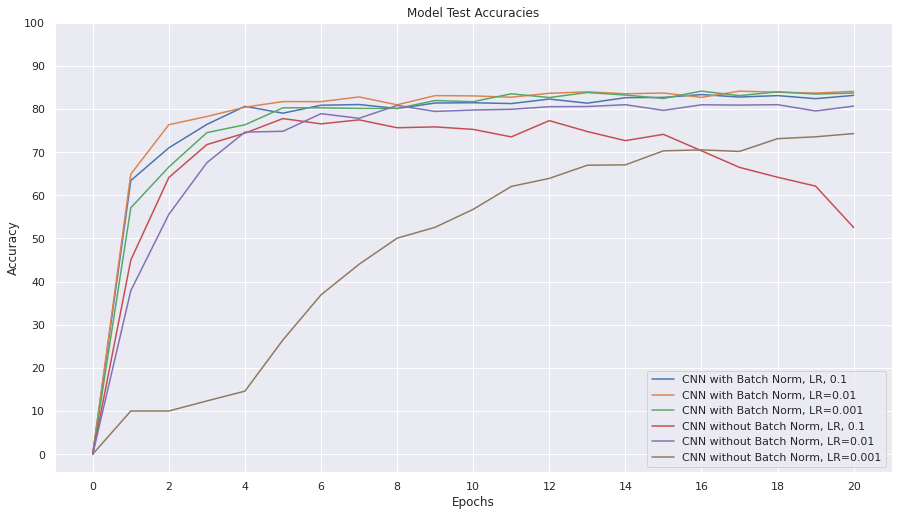

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.title("Model Test Accuracies")
plt.plot(batchnorm_acc_c, label='CNN with Batch Norm, LR, 0.1')
plt.plot(batchnorm_acc_b, label='CNN with Batch Norm, LR=0.01')
plt.plot(batchnorm_acc_a, label='CNN with Batch Norm, LR=0.001')
plt.plot(nonbatchnorm_acc_c, label='CNN without Batch Norm, LR, 0.1')
plt.plot(nonbatchnorm_acc_b, label='CNN without Batch Norm, LR=0.01')
plt.plot(nonbatchnorm_acc_a, label='CNN without Batch Norm, LR=0.001')
plt.yticks(np.arange(0,110,step=10))
plt.xticks(np.arange(0,21,step=2))
plt.legend(loc="lower right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

**3. Batch Norm vs Non-Batch Norm: Effect on convergence of Model**

In [0]:
a = test_acc

b = [0, 37.89,
 55.58,
 67.56,
 74.65,
 74.84,
 78.92,
 77.85,
 80.84,
 79.44]

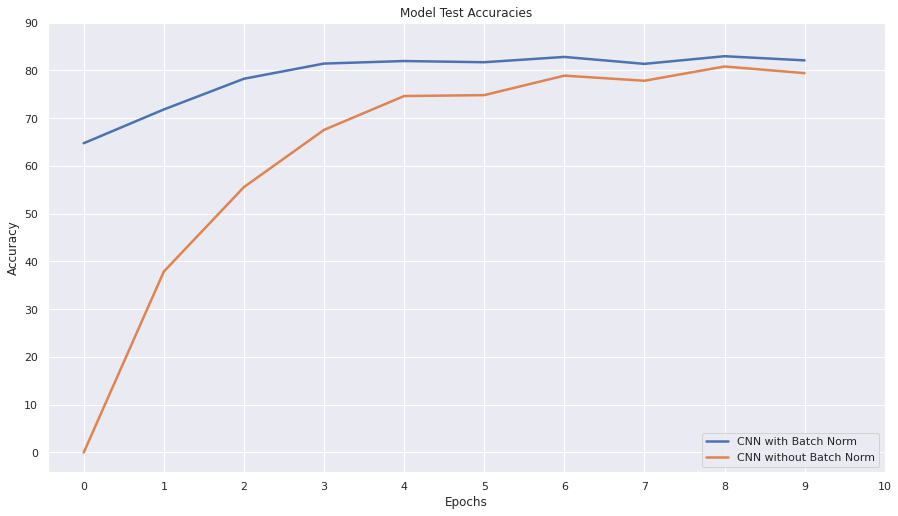

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.title("Model Test Accuracies")
plt.plot(a, label='CNN with Batch Norm', linewidth = 2.5)
plt.plot(b, label='CNN without Batch Norm', linewidth = 2.5)
plt.yticks(np.arange(0,100,step=10))
plt.xticks(np.arange(0,11,step=1))
plt.legend(loc="lower right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()